In [1]:
# ==========================================
# 1. IMPORTS
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # <--- Added for saving the model

# Machine Learning Imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# Set global display option
pd.set_option('display.max_columns', None)


In [2]:
# ==========================================
# 2. DATA LOADING & CLEANING
# ==========================================
file_path = "cleaned_data_green_taxi_2013_chunk_3.csv" 

try:
    df = pd.read_csv(file_path)
    print("✅ Dataset loaded successfully.")
except FileNotFoundError:
    print(f"❌ Error: File not found at {file_path}. Using dummy data for demonstration.")
    # Dummy data creation (same as before)
    df = pd.DataFrame({
        'pickup_date': ['01-01-2013']*100, 'pickup_time': ['12:00:00']*100,
        'dropoff_date': ['01-01-2013']*100, 'dropoff_time': ['12:15:00']*100,
        'Passenger_count': np.random.choice([1, 2], 100),
        'Fare_amount': np.random.rand(100)*20, 'Trip_distance': np.random.rand(100)*5,
        'Extra': [0.5]*100, 'MTA_tax': [0.5]*100, 'Tip_amount': [1.0]*100,
        'Tolls_amount': [0.0]*100, 'Total_amount': np.random.rand(100)*25,
        'Payment_type': [1]*100, 'Trip_type': [1]*100, 'rate_code': [1]*100,
        'Store_and_fwd_flag': ['N']*100,
        'Pickup_longitude': [-73.9]*100, 'Pickup_latitude': [40.7]*100,
        'Dropoff_longitude': [-73.9]*100, 'Dropoff_latitude': [40.7]*100,
        'Difference_between_p_d_time': ['00:15:00']*100
    })

# Date/Time conversion
df['pickup_datetime'] = pd.to_datetime(df['pickup_date'] + ' ' + df['pickup_time'], format='%d-%m-%Y %H:%M:%S', errors='coerce')
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_date'] + ' ' + df['dropoff_time'], format='%d-%m-%Y %H:%M:%S', errors='coerce')

# Drop original date/time columns
df = df.drop(['pickup_date', 'pickup_time', 'dropoff_date', 'dropoff_time'], axis=1, errors='ignore')

# Handle missing values
df['Trip_type'] = df['Trip_type'].fillna(2).astype(int)


✅ Dataset loaded successfully.


In [3]:

# ==========================================
# 3. FEATURE ENGINEERING
# ==========================================
df['trip_duration_min'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['is_weekend'] = df['pickup_day_of_week'].isin([5, 6]).astype(int)
df['log_trip_distance'] = np.log1p(df['Trip_distance']) 
df['distance_duration_interaction'] = df['Trip_distance'] * df['trip_duration_min']

# Outlier Removal
df = df[(df['Fare_amount'] > 0) & (df['Fare_amount'] < 100)]
df = df[(df['Trip_distance'] > 0) & (df['Trip_distance'] < 50)]
df = df[(df['trip_duration_min'] > 0) & (df['trip_duration_min'] < 120)]

print(f"Dataset shape after cleaning: {df.shape}")


Dataset shape after cleaning: (287356, 26)


In [ ]:

# ==========================================
# 4. EXPLORATORY DATA ANALYSIS (EDA)
# ==========================================



## 🧾 1. Univariate Analysis (Single Variable)

**Goal:** Understand the distribution, central tendency, and spread of individual features.

### 🔹 Example 1: Passenger Count Distribution

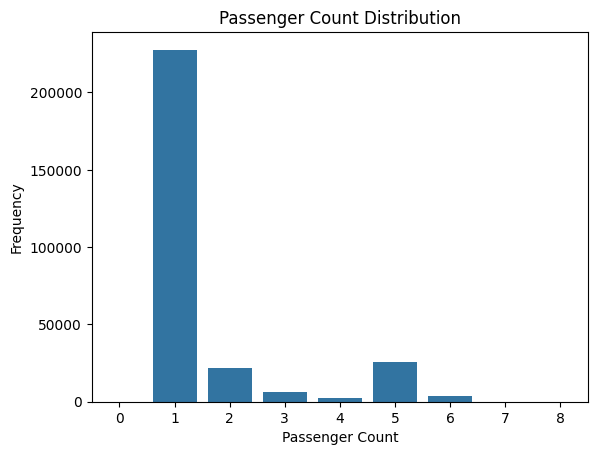

In [4]:
sns.countplot(data=df, x='Passenger_count')
plt.title("Passenger Count Distribution")
plt.xlabel("Passenger Count")
plt.ylabel("Frequency")
plt.show() 


**Explanation:** Helps us see how many trips occurred with how many passengers. Peaks at 1 show most people traveled alone.
### 🔹 Example 2: Fare Amount Distribution

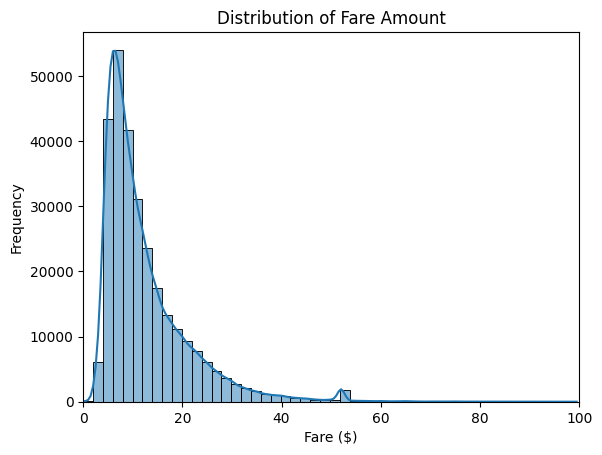

In [5]:
sns.histplot(df['Fare_amount'], bins=50, kde=True)
plt.title("Distribution of Fare Amount")
plt.xlabel("Fare ($)")
plt.ylabel("Frequency")
plt.xlim(0, 100)  # Limit to remove extreme outliers
plt.show()

**Explanation:** Reveals the typical fare amounts and helps detect outliers (very high fare values).
### 🔹 Example 3: Trip Duration (Derived Column)

In [6]:
# Force conversion to datetime (this handles format issues or hidden strings)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], errors='coerce')

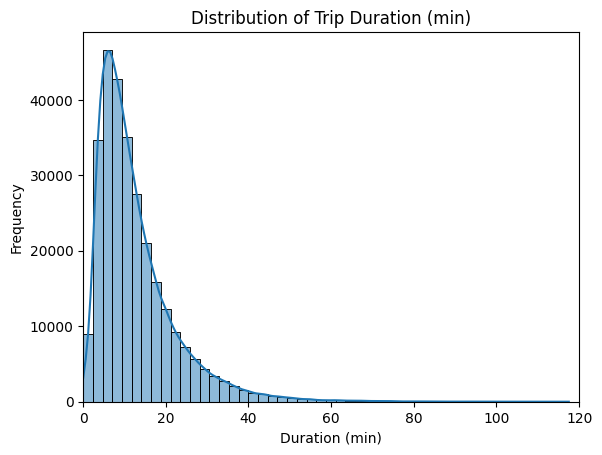

In [7]:
df['trip_duration_min'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60

sns.histplot(df['trip_duration_min'], bins=50, kde=True)
plt.title("Distribution of Trip Duration (min)")
plt.xlabel("Duration (min)")
plt.ylabel("Frequency")
plt.xlim(0, 120)
plt.show()

**Explanation:** Uncovers average trip times and potential anomalies (e.g., trips lasting hours).

### 🔹 4. Total Amount Distribution (with outliers)

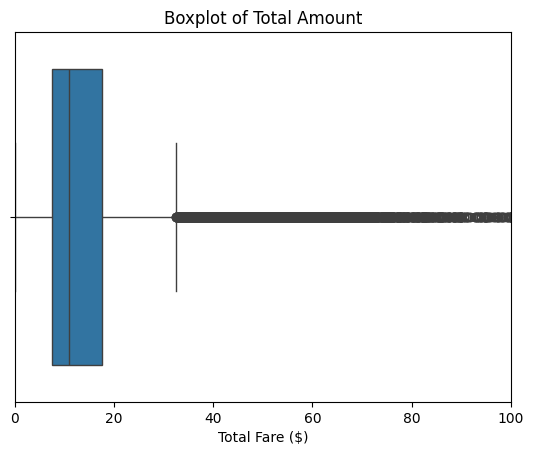

In [8]:
sns.boxplot(x=df['Total_amount'])
plt.title("Boxplot of Total Amount")
plt.xlabel("Total Fare ($)")
plt.xlim(0, 100)
plt.show()

**Why:** Identifies outliers (extremely high values) that might need attention during modeling.

---
### 🔹 5. Distribution of Trip Distance (Log scale)

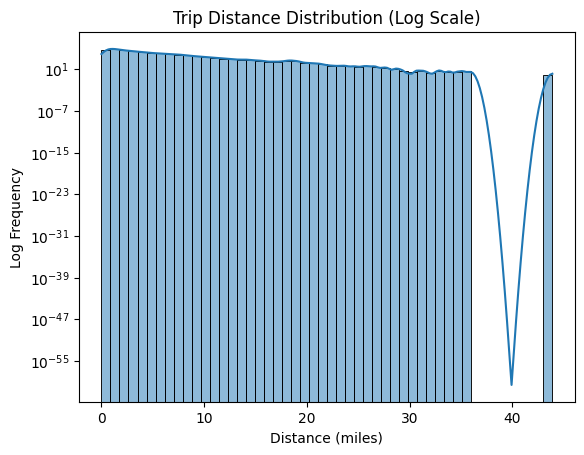

In [9]:
sns.histplot(df['Trip_distance'], bins=50, kde=True)
plt.yscale("log")
plt.title("Trip Distance Distribution (Log Scale)")
plt.xlabel("Distance (miles)")
plt.ylabel("Log Frequency")
plt.show()

**Why:** If distance is right-skewed, using a log scale helps visualize the long tail.
### 🔹 6. Distribution of Tips

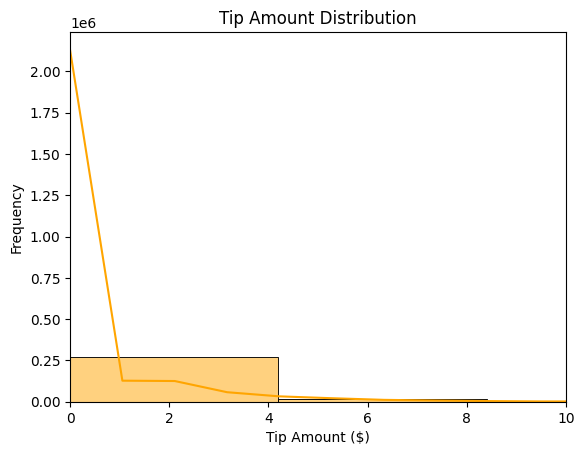

In [10]:
sns.histplot(df['Tip_amount'], bins=50, kde=True, color='orange')
plt.title("Tip Amount Distribution")
plt.xlabel("Tip Amount ($)")
plt.ylabel("Frequency")
plt.xlim(0, 10)
plt.show()

**Why:** Tips are often zero or small values—this helps visualize tip behavior.
---

## 🔗 2. Bivariate Analysis (Two Variables)

**Goal:** Explore relationships or dependencies between two variables.

---
### 🔹 Example 1: Fare Amount vs. Trip Distance

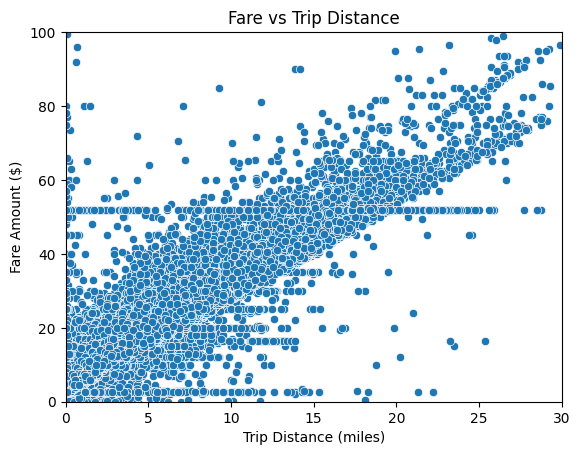

In [11]:
sns.scatterplot(data=df, x='Trip_distance', y='Fare_amount')
plt.title("Fare vs Trip Distance")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.xlim(0, 30)
plt.ylim(0, 100)
plt.show()

**Explanation:** Positive correlation — longer trips usually cost more. Outliers may indicate errors or flat fares.

---

### 🔹 Example 2: Payment Type vs. Total Amount

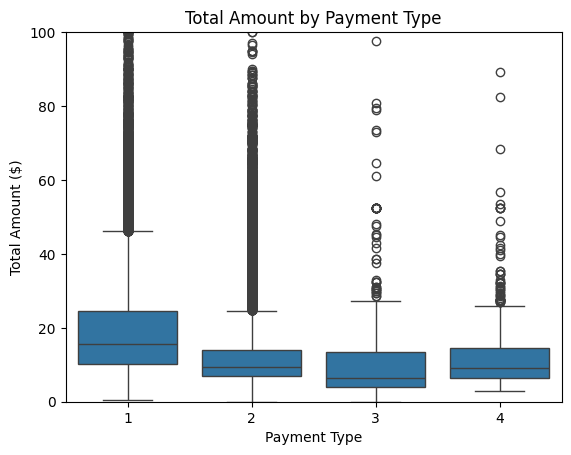

In [12]:
sns.boxplot(data=df, x='Payment_type', y='Total_amount')
plt.title("Total Amount by Payment Type")
plt.xlabel("Payment Type")
plt.ylabel("Total Amount ($)")
plt.ylim(0, 100)
plt.show()

**Explanation:** Compares total bill distribution between cash/card. Useful to detect whether high payments cluster by type.

---

### 🔹 Example 3: Tip Amount vs. Payment Type

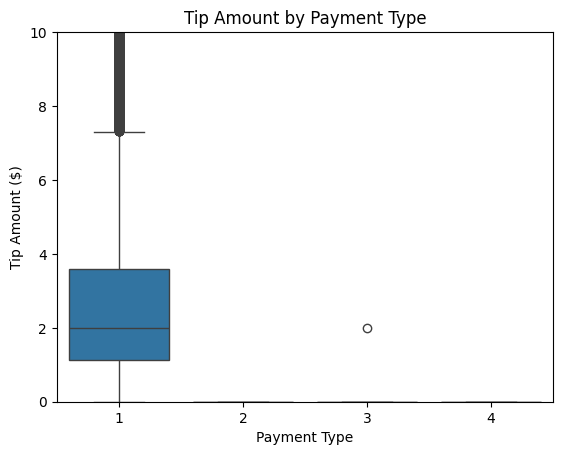

In [13]:
sns.boxplot(data=df, x='Payment_type', y='Tip_amount')
plt.title("Tip Amount by Payment Type")
plt.xlabel("Payment Type")
plt.ylabel("Tip Amount ($)")
plt.ylim(0, 10)
plt.show()

**Explanation:** Typically, tips are only given in card payments (`Payment_type == 1`), so this analysis confirms behavior.

---
### 🔹 4. Total Amount vs. Trip Duration

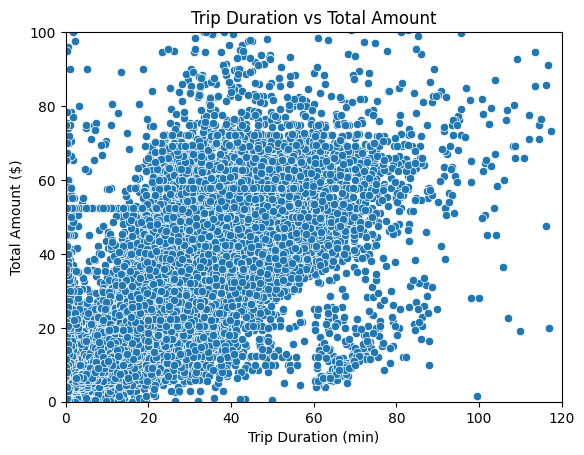

In [14]:
sns.scatterplot(x='trip_duration_min', y='Total_amount', data=df)
plt.title("Trip Duration vs Total Amount")
plt.xlabel("Trip Duration (min)")
plt.ylabel("Total Amount ($)")
plt.xlim(0, 120)
plt.ylim(0, 100)
plt.show()

**Why:** Highlights whether longer trips consistently have higher costs.
### 🔹 5. Trip Distance by Rate Code

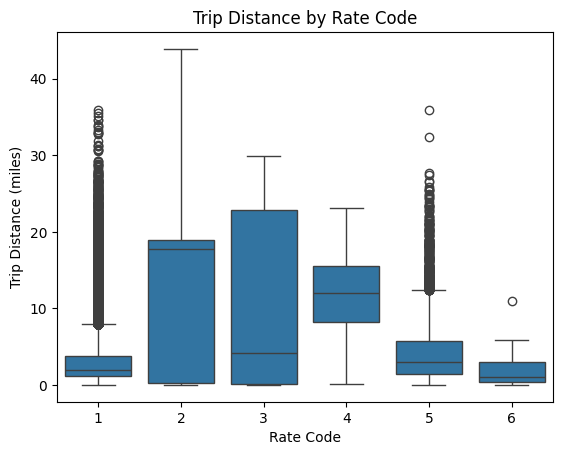

In [15]:
sns.boxplot(x='rate_code', y='Trip_distance', data=df)
plt.title("Trip Distance by Rate Code")
plt.xlabel("Rate Code")
plt.ylabel("Trip Distance (miles)")
plt.show()

**Why:** See how different fare codes affect travel distance—some may represent flat-rate zones.

### 🔹 6. Passenger Count vs. Total Amount (Boxplot)

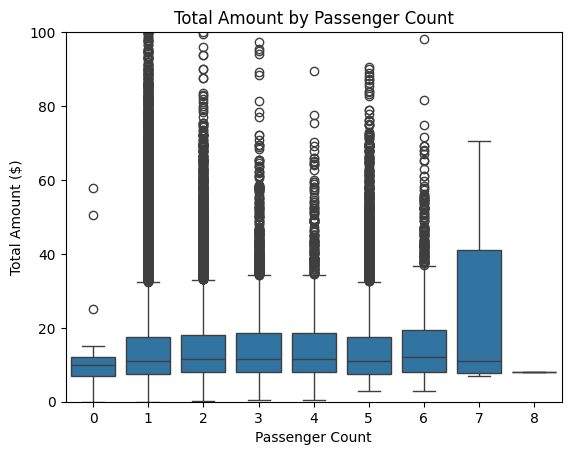

In [16]:
sns.boxplot(data=df, x='Passenger_count', y='Total_amount')
plt.title("Total Amount by Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Total Amount ($)")
plt.ylim(0, 100)
plt.show()

**Why:** Understand if more passengers lead to higher fares or not.



## 🔗🔗 3. Multivariate Analysis (Three or More Variables)

**Goal:** Understand interaction between multiple variables simultaneously.

---

### 🔹 Example 1: Trip Distance vs. Fare by Passenger Count


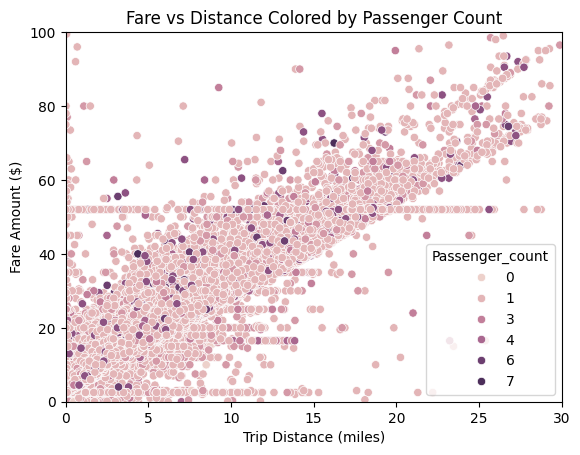

In [17]:
sns.scatterplot(data=df, x='Trip_distance', y='Fare_amount', hue='Passenger_count')
plt.title("Fare vs Distance Colored by Passenger Count")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.xlim(0, 30)
plt.ylim(0, 100)
plt.show()


**Explanation:** Adds depth by showing how the number of passengers might influence fares or distance.

---

### 🔹 Example 2: Heatmap of Correlation Matrix



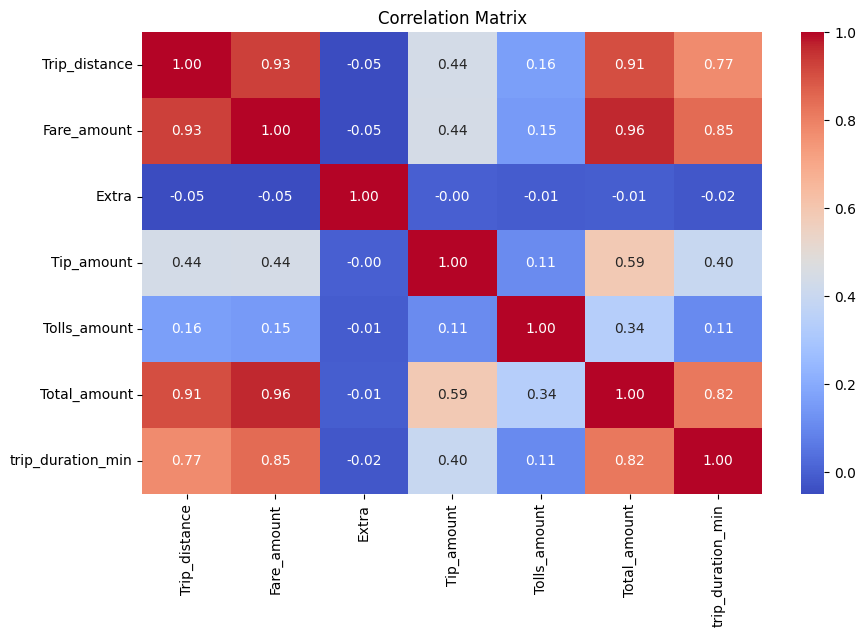

In [18]:
num_cols = ['Trip_distance', 'Fare_amount', 'Extra', 'Tip_amount', 'Tolls_amount', 'Total_amount', 'trip_duration_min']

plt.figure(figsize=(10, 6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


**Explanation:** Shows linear relationships. Helps detect multicollinearity for modeling and identify strong pairwise relationships.

---

### 🔹 Example 3: Time vs Fare vs Tip (using Hour of Day)


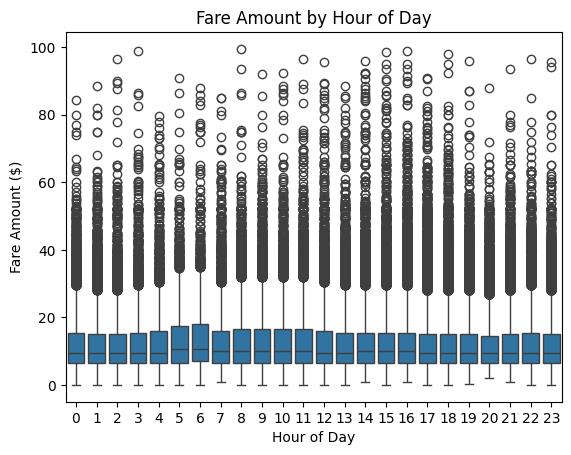

In [19]:
df['hour_of_day'] = df['pickup_datetime'].dt.hour

sns.boxplot(x='hour_of_day', y='Fare_amount', data=df)
plt.title("Fare Amount by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Fare Amount ($)")
plt.show()


**Explanation:** Useful for understanding demand or surge pricing by hour (e.g., higher fares during rush hours).

---
### 🔹 4. Fare vs. Distance by Payment Type


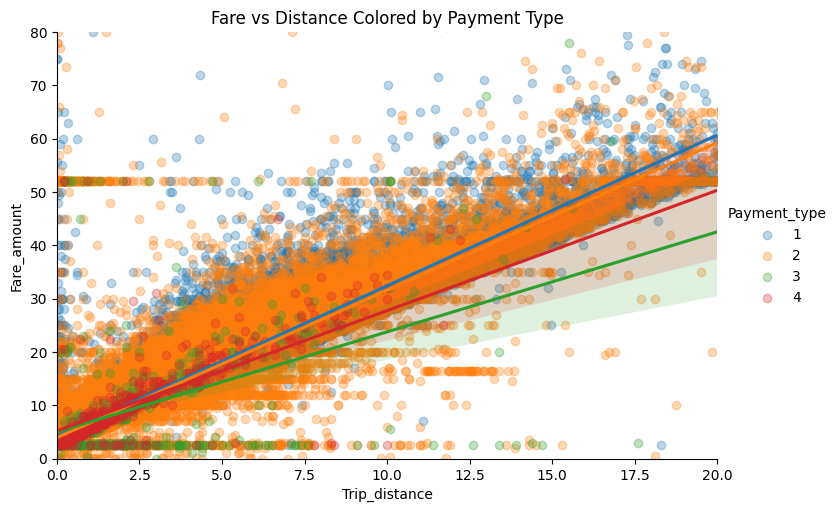

In [20]:
sns.lmplot(data=df, x='Trip_distance', y='Fare_amount', hue='Payment_type', aspect=1.5, scatter_kws={'alpha':0.3})
plt.title("Fare vs Distance Colored by Payment Type")
plt.xlim(0, 20)
plt.ylim(0, 80)
plt.show()

**Why:** Shows how fare and distance relate across payment methods—linear trends could differ.
### 🔹 5. Pickup Time of Day vs. Passenger Count Heatmap

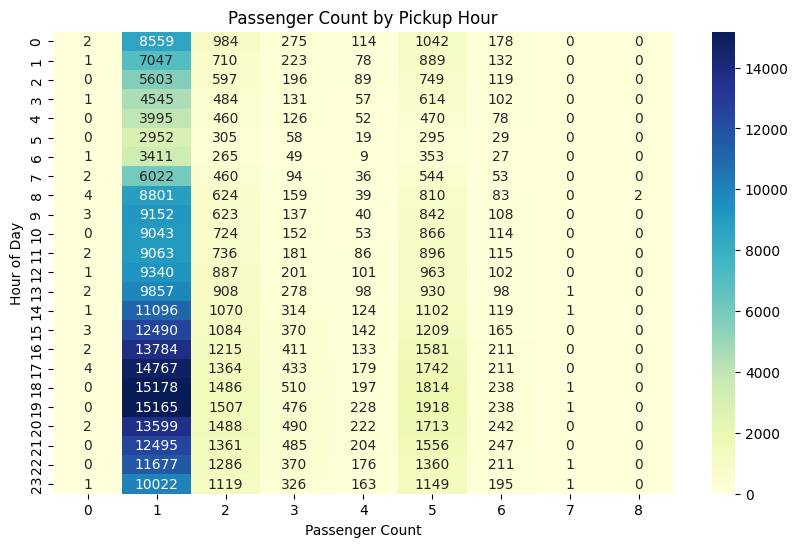

In [21]:
df['pickup_hour'] = df['pickup_datetime'].dt.hour
pivot = df.pivot_table(index='pickup_hour', columns='Passenger_count', values='Total_amount', aggfunc='count', fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap='YlGnBu', annot=True, fmt='d')
plt.title("Passenger Count by Pickup Hour")
plt.xlabel("Passenger Count")
plt.ylabel("Hour of Day")
plt.show()

**Why:** Reveals hourly patterns of group travel—helpful for fleet management or marketing.
### 🔹 6. Jointplot: Fare Amount vs Tip Amount

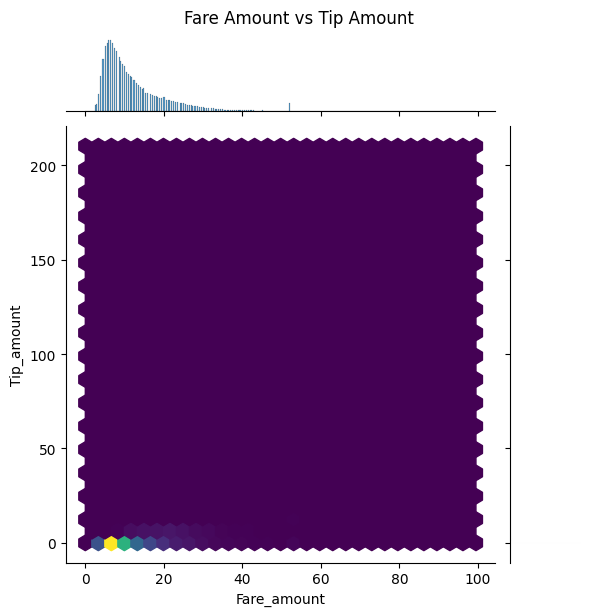

In [22]:
sns.jointplot(data=df, x='Fare_amount', y='Tip_amount', kind='hex', gridsize=30, cmap="viridis")
plt.suptitle("Fare Amount vs Tip Amount", y=1.02)
plt.show()

**Why:** Joint distribution with hex bins highlights how tipping behaves relative to fare size.
## 📊 Optional: Categorical Count Charts

---

### 🔹 A. Count of Payment Types

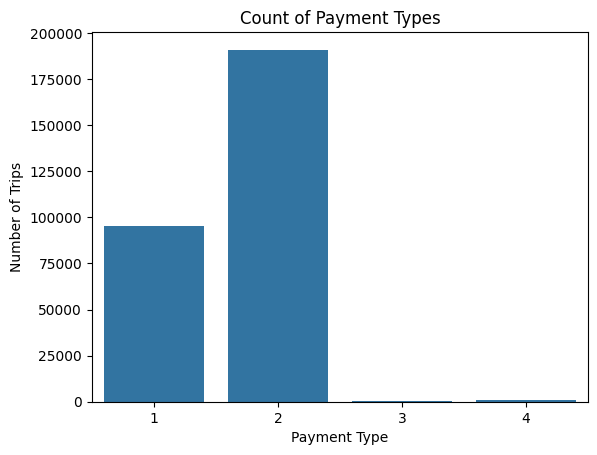

In [23]:
sns.countplot(data=df, x='Payment_type')
plt.title("Count of Payment Types")
plt.xlabel("Payment Type")
plt.ylabel("Number of Trips")
plt.show()

### 🔹 B. Count of Rate Codes

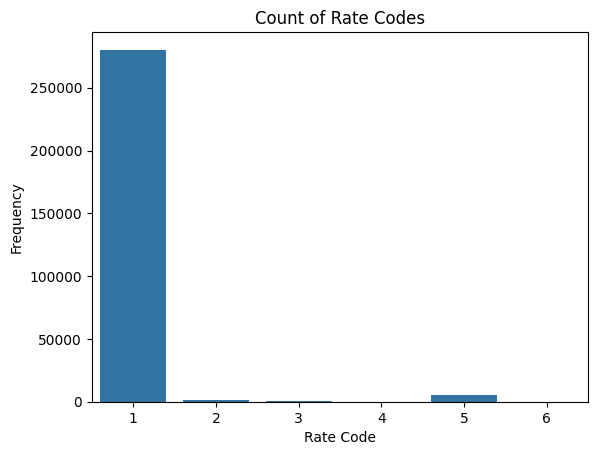

In [24]:
sns.countplot(data=df, x='rate_code')
plt.title("Count of Rate Codes")
plt.xlabel("Rate Code")
plt.ylabel("Frequency")
plt.show()

In [29]:
# ==========================================
# 5. MODEL PREPARATION
# ==========================================
df_sample = df.sample(n=100000, random_state=42) # Adjust sample size if needed

# Encoding
categorical_columns = ['Store_and_fwd_flag', 'Payment_type', 'Trip_type', 'rate_code']
df_sample = pd.get_dummies(df_sample, columns=categorical_columns, drop_first=True)

# Define X and y
exclude_columns = ['Fare_amount', 'Tip_amount', 'Total_amount', 'pickup_datetime', 'dropoff_datetime', 'Difference_between_p_d_time']
X = df_sample.drop(columns=exclude_columns, errors='ignore')
y = df_sample['Fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:

# ==========================================
# 6. MODEL TRAINING & TUNING
# ==========================================
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Pipeline([('scaler', StandardScaler()), ('reg', Ridge())]),
    'Lasso Regression': Pipeline([('scaler', StandardScaler()), ('reg', Lasso(max_iter=2000))]),
    'Elastic Net': Pipeline([('scaler', StandardScaler()), ('reg', ElasticNet(max_iter=2000))]),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    'SVR': Pipeline([('scaler', StandardScaler()), ('reg', SVR())]),
    'KNN': Pipeline([('scaler', StandardScaler()), ('reg', KNeighborsRegressor())])
}

param_grids = {
    'Ridge Regression': {'reg__alpha': [0.1, 1.0, 10.0]},
    'Lasso Regression': {'reg__alpha': [0.01, 0.1, 1.0]},
    'Elastic Net': {'reg__alpha': [0.01, 0.1], 'reg__l1_ratio': [0.5, 0.7]},
    'Decision Tree': {'max_depth': [5, 10, 15], 'min_samples_split': [5, 10]},
    'Random Forest': {'n_estimators': [50, 100], 'max_depth': [10, 15]},
    'XGBoost': {'n_estimators': [50, 100], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 6]},
    'KNN': {'reg__n_neighbors': [3, 5, 7]}
}

results = []
trained_models = {}  # <--- Dictionary to store trained model objects
all_predictions = pd.DataFrame({'Actual': y_test.reset_index(drop=True)})

print("\nTraining Models...")

for name, model in models.items():
    try:
        if name in param_grids:
            grid = GridSearchCV(model, param_grids[name], cv=3, scoring='r2', n_jobs=-1)
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            print(f"✅ {name} tuned.")
        else:
            best_model = model
            best_model.fit(X_train, y_train)
            print(f"✅ {name} trained.")

        # Store the trained model
        trained_models[name] = best_model  # <--- Saving model object here

        # Predict & Evaluate
        y_pred = best_model.predict(X_test)
        all_predictions[name] = y_pred

        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        results.append({'Model': name, 'R²': r2, 'MSE': mse, 'MAE': mae})

    except Exception as e:
        print(f"❌ Error with {name}: {str(e)}")



Training Models...
✅ Linear Regression trained.
✅ Ridge Regression tuned.
✅ Lasso Regression tuned.
✅ Elastic Net tuned.
✅ Decision Tree tuned.
✅ Random Forest tuned.
✅ XGBoost tuned.
✅ SVR trained.
✅ KNN tuned.


In [ ]:

# ==========================================
# 7. RESULTS & SAVING BEST MODEL
# ==========================================
results_df = pd.DataFrame(results).sort_values(by='R²', ascending=False)
print("\n🏆 Model Performance Leaderboard:")
print(results_df)

# Identify Best Model Name
best_model_name = results_df.iloc[0]['Model']
best_model_object = trained_models[best_model_name]

print(f"\n🌟 The best performing model is: {best_model_name}")

# Save the Best Model
filename = 'best_model_green_taxi_trained_on_100000_sample.pkl'
joblib.dump(best_model_object, filename)
print(f"💾 Model saved successfully as '{filename}'.")

# Model        R²       MSE       MAE
# XGBoost  0.955343  3.242817  0.617899 sample size 10000
# XGBoost  0.971827  2.227837  0.479075 sample size 100000


🏆 Model Performance Leaderboard:
               Model        R²       MSE       MAE
6            XGBoost  0.971827  2.227837  0.479075
5      Random Forest  0.970602  2.324763  0.468144
4      Decision Tree  0.963908  2.854052  0.558845
8                KNN  0.948103  4.103879  0.949291
0  Linear Regression  0.919610  6.357090  0.752175
1   Ridge Regression  0.919610  6.357095  0.752177
2   Lasso Regression  0.919113  6.396384  0.755568
3        Elastic Net  0.919039  6.402204  0.764064
7                SVR  0.918445  6.449185  0.594643

🌟 The best performing model is: XGBoost
💾 Model saved successfully as 'best_model_green_taxi_trained_on_100000_sample.pkl'.
